### Theory of bed profile forms implemented in some numpy functions
A bed profile model is required to estimate the bathymetry of a channel in 2D. Here we identify a set of functions to estimate the depth profile from a set of parameters that can be measured iun-situ or (ideally!) only at the side of the channel from drone footage. The angles at the sides of the channel are, according to Savenije 2003 and referenced authors, a good representation of bed form similarities. We therefore take these assumed relationships as starting point for our assessment.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

ModuleNotFoundError: No module named 'seaborn'

## Replication of figure 1 in Savenije 2003

Text(0, 0.5, 'Depth +shore [m]')

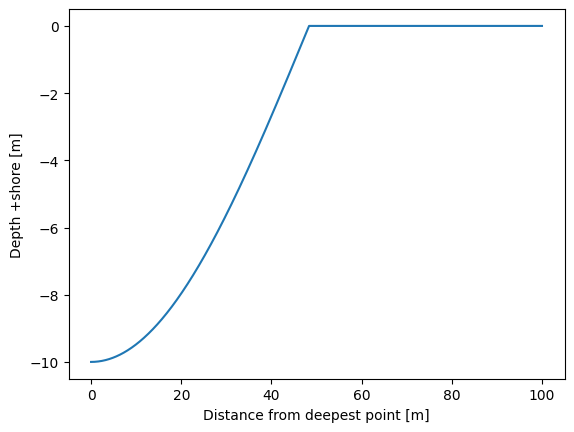

In [3]:
# let's start with some coordinates from left (0) to right bank

def depth_from_width(s, phi=0.1*np.pi, h_m=10):
    """
    Simplest implementation of Eq. 12 from Savenije 2003, where the first coordinate (zero meters) is the lowest point. We stop at zero as that
    is where we reach the natural levee crest.
    """
    # zero is the lowest point in the stream starting in the middle of the stream
    angle = np.minimum(np.tan(phi)/h_m * s, 0.5*np.pi)
    depth = -np.cos(angle)*h_m
    return depth


s = np.linspace(0, 100, 1000)

depth = depth_from_width(s)

plt.plot(s, depth)
plt.xlabel("Distance from deepest point [m]")
plt.ylabel("Depth +shore [m]")


## Implementation over an entire symmetrical channel

Now we assume that the left coordinate is at the natural levee's left bank and the right at the natural levee's right bank.
We can now no longer use both `h_m` and `phi`. We have to resolve one of them to be able to solve the problem.

In [4]:
def depth_profile_from_parameters(s, phi=None, h_m=None):
    """
    Solving the entire profile using a symmetrical assumption and either phi or h_m defined
    """
    if phi is None and h_m is None:
        raise ValueError("Either phi or h_m has to be supplied. You supplied nothing.")
    if phi is not None and h_m is not None:
        raise ValueError("Either phi or h_m has to be supplied. You supplied both. Select either one of the two")
    # compute the total width of the channel
    B = s[-1] - s[0]
    if phi is None:
        # h_m was supplied, so resolve for phi
        phi = np.arctan(np.pi*h_m/B)
    else:
        # phi was supplied, so resolve for h_m
        h_m = B*np.tan(phi)/np.pi
    # compute ordinate coordinates (i.e. from center line towards banks)
    _s = s - 0.5*B
    return depth_from_width(_s, phi=phi, h_m=h_m)
    



## Test over a set of natural angles of repose
Let's see what happens with different angles of repose. We should be assuming that milder angles lead to shallower water

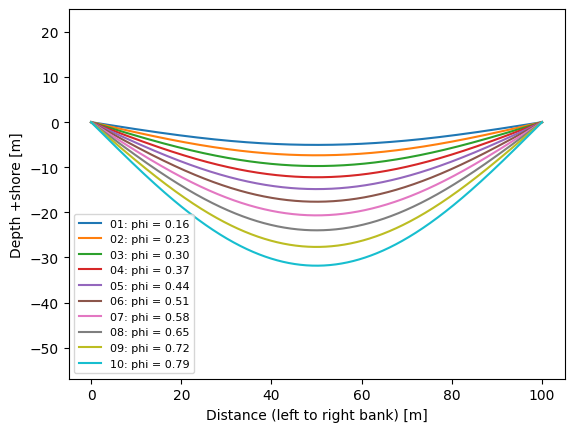

In [5]:

for n, phi in enumerate(np.linspace(0.05*np.pi, 0.25*np.pi, 10)):
    depth = depth_profile_from_parameters(s, phi=phi)
    plt.plot(s, depth, label="{:02d}: phi = {:1.2f}".format(n + 1, phi))
    plt.xlabel("Distance (left to right bank) [m]")
    plt.ylabel("Depth +shore [m]")
plt.axis("equal")
plt.legend(fontsize=8)

Text(0.5, 1.0, 'asymmetrical profile shape')

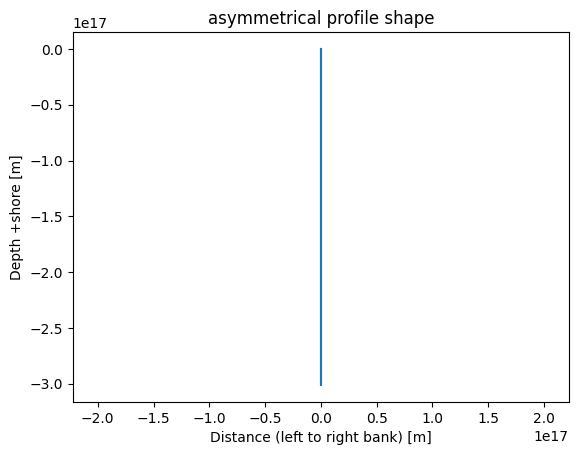

In [14]:
# left bank
def depth_profile_left_right_parameters(s, phi_left, phi_right):
    depths_left = depth_profile_from_parameters(s, phi=phi_left)
    # right bank
    depths_right = depth_profile_from_parameters(s, phi=phi_right)
    weights = np.linspace(0, 1, len(s))
    return (1 - weights) * depths_left + weights * depths_right
    
s = np.linspace(0, 100, 100)
depths = depth_profile_left_right_parameters(s, phi_left=0.5*np.pi, phi_right=0.1*np.pi)
plt.plot(s, depths)
plt.axis("equal")
plt.xlabel("Distance (left to right bank) [m]")
plt.ylabel("Depth +shore [m]")
plt.title("asymmetrical profile shape")

In [25]:
0.2*180

36.0

### Asymmetrical channel behaviour
A channel bed is usually not entirely symmetrical, so we can also assume that some further constraints may be necessary to assess the width/depth relationship. If we supply the left and right angle, then this does not necessarily mean that the depth can be resolved from that, as they may to a certain degree counter. Hence we have to optimize the location over the cross section where the depth is at maximum.



In [6]:
#TODO